In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from keras_tuner import RandomSearch

forex_df = pd.read_pickle("../data/GBP_JPY_H1.pkl")

In [24]:
forex_df.columns

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c'],
      dtype='object')

In [25]:
forex_df.drop(['bid_o', 'bid_h','bid_l', 'bid_c', 'ask_o','ask_h', 'ask_l', 'ask_c'], axis=1, inplace=True)

In [26]:
def apply_direction(df):
    direction = df.mid_c - df.mid_o
    direction = [1 if x >= 0 else -1 for x in direction]
    df['direction'] = direction

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Function to create sequences
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
backtest_split = len(forex_df) - int(len(forex_df)*0.5)

# DataFrame used for training, hyperparameter tuning, and testing prediction accuracy
df = forex_df.iloc[:backtest_split]

# DataFrame used for backtesting trading
backtest_df = forex_df.iloc[backtest_split:]

In [29]:
def preprocess_data(df):

    data = df['mid_c'].values.reshape(-1, 1)  # Assuming 'mid_c' is the column for mid closing prices

    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)

    # Specify the number of lag hours
    n_hours = 5  # Number of hours from the past to use
    n_features = 1  # Number of features (since we are only using 'mid_c' here)
    n_forecast = 3  # Predict 1 hour ahead

    # Create sequences
    X, y = create_sequences(data_scaled, n_hours, n_forecast)
    y = y[:, 0]  

    # Split the data into training and test sets
    return train_test_split(X, y, test_size=0.2, random_state=42)
    

In [32]:
X_train, X_test, y_train, y_test = preprocess_data(df)

In [34]:
len(X_train)

14884

In [11]:
y[0]

array([0.926666])

In [12]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=30, max_value=120, step=30),
                  return_sequences=True,
                  input_shape=(n_hours, n_features)))
    model.add(GRU(units=hp.Int('units', min_value=30, max_value=120, step=30)))
    model.add(Dense(1))
    
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error')
    return model

In [13]:
# Set up the tuner
tuner = RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='Forex_GRU_Tuning'
)

# Execute the hyperparameter search
tuner.search(X, y, epochs=5, validation_split=0.2, verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first and second GRU layers is {best_hps.get('units')} and
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters.
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=2)

Reloading Tuner from tuner_results\Forex_GRU_Tuning\tuner0.json

The optimal number of units in the first and second GRU layers is 90 and
the optimal learning rate for the optimizer is 0.001.


Epoch 1/5

372/372 - 6s - loss: 0.0023 - val_loss: 3.8794e-05 - 6s/epoch - 16ms/step
Epoch 2/5
372/372 - 2s - loss: 6.5667e-05 - val_loss: 4.8815e-05 - 2s/epoch - 6ms/step
Epoch 3/5
372/372 - 2s - loss: 6.6490e-05 - val_loss: 3.5965e-05 - 2s/epoch - 5ms/step
Epoch 4/5
372/372 - 2s - loss: 6.8201e-05 - val_loss: 3.8277e-05 - 2s/epoch - 6ms/step
Epoch 5/5
372/372 - 2s - loss: 6.6763e-05 - val_loss: 4.5666e-05 - 2s/epoch - 6ms/step


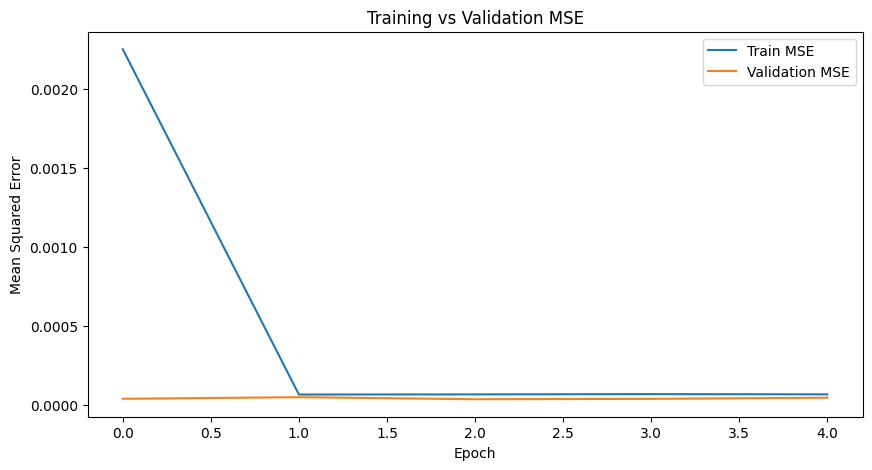

In [14]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Training vs Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [16]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

117/117 [==============================] - 1s 4ms/step
Mean Squared Error on Test Set: 5.425147137742789e-05


In [17]:
# Define thresholds
threshold_pct = 0.01  # 1% change
stop_loss_pct = 0.005  # 0.5%
take_profit_pct = 0.015  # 1.5%

# Calculate signals
backtest_df['price_change'] = (backtest_df['future_mid_c'] - backtest_df['mid_c']) / backtest_df['mid_c']

# Generate trading signals
backtest_df['signal'] = np.where(backtest_df['price_change'] > threshold_pct, 'Buy',
                        np.where(backtest_df['price_change'] < -threshold_pct, 'Sell', 'Hold'))

# Calculate stop loss and take profit prices for each trade
backtest_df['stop_loss'] = np.where(backtest_df['signal'] == 'Buy', backtest_df['mid_c'] * (1 - stop_loss_pct),
                           np.where(backtest_df['signal'] == 'Sell', backtest_df['mid_c'] * (1 + stop_loss_pct), np.nan))

backtest_df['take_profit'] = np.where(backtest_df['signal'] == 'Buy', backtest_df['mid_c'] * (1 + take_profit_pct),
                             np.where(backtest_df['signal'] == 'Sell', backtest_df['mid_c'] * (1 - take_profit_pct), np.nan))

backtest_df = backtest_df[['time', 'mid_c', 'future_mid_c', 'signal', 'stop_loss', 'take_profit']]

C:\Users\aryan\AppData\Local\Temp\ipykernel_5628\3146062622.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_df['price_change'] = (backtest_df['future_mid_c'] - backtest_df['mid_c']) / backtest_df['mid_c']
C:\Users\aryan\AppData\Local\Temp\ipykernel_5628\3146062622.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest_df['signal'] = np.where(backtest_df['price_change'] > threshold_pct, 'Buy',
C:\Users\aryan\AppData\Local\Temp\ipykernel_5628\3146062622.py:14: SettingWithCopyWarning: 
A va

In [18]:
backtest_df[backtest_df.signal != 'Hold']

,time,mid_c,future_mid_c,signal,stop_loss,take_profit
18785,2019-01-15 17:00:00+00:00,138.286,140.006,Buy,137.59457,140.36029
18786,2019-01-15 18:00:00+00:00,137.906,139.792,Buy,137.21647,139.97459
19737,2019-03-12 08:00:00+00:00,147.306,145.301,Sell,148.04253,145.09641
19738,2019-03-12 09:00:00+00:00,147.070,145.572,Sell,147.80535,144.86395
22383,2019-08-13 10:00:00+00:00,127.158,128.767,Buy,126.52221,129.06537
...,...,...,...,...,...,...
30107,2020-11-09 09:00:00+00:00,136.174,138.244,Buy,135.49313,138.21661
30108,2020-11-09 10:00:00+00:00,136.306,138.228,Buy,135.62447,138.35059
30109,2020-11-09 11:00:00+00:00,137.228,138.616,Buy,136.54186,139.28642
30583,2020-12-07 05:00:00+00:00,139.652,138.102,Sell,140.35026,137.55722


In [35]:
def simulate_trading(df, model, window_size, stop_loss_pct, take_profit_pct):
    capital = 10000  # Starting capital, in dollars
    position_size = 1000  # Size of each trade, in dollars

    # Calculate the initial number of units to buy/sell per trade
    df['units'] = position_size / df['mid_c']

    # Predict future prices using the GRU model
    predictions = []
    for i in range(window_size, len(df) - 1):
        input_seq = df['mid_c'].iloc[i - window_size:i].values.reshape(1, window_size, 1)
        predicted_price = model.predict(input_seq)
        predictions.append(predicted_price[0][0])
    df['predicted_price'] = pd.Series(predictions, index=df.index[window_size + 1:])

    # Initialize the trade log
    trades = []
    
    # Loop through the dataframe and make trades based on predictions
    for i in range(window_size + 1, len(df) - 1):
        current_price = df.at[i, 'mid_c']
        predicted_price = df.at[i, 'predicted_price']
        units = df.at[i, 'units']
        
        # Decide whether to buy or sell
        if predicted_price > current_price:  # Predicts price will go up
            entry_price = df.at[i + 1, 'mid_c']  # Buy at next available price
            stop_loss = entry_price * (1 - stop_loss_pct)
            take_profit = entry_price * (1 + take_profit_pct)
            action = 'Buy'
        else:  # Predicts price will go down
            entry_price = df.at[i + 1, 'mid_c']  # Sell at next available price
            stop_loss = entry_price * (1 + stop_loss_pct)
            take_profit = entry_price * (1 - take_profit_pct)
            action = 'Sell'
        
        # Assume the trade closes at the stop loss or take profit
        close_price = take_profit if action == 'Buy' else stop_loss
        pnl = units * (close_price - entry_price) if action == 'Buy' else units * (entry_price - close_price)
        
        # Record the trade
        trades.append({'entry': entry_price, 'close': close_price, 'pnl': pnl, 'action': action})
    
    # Calculate final capital after trades
    final_pnl = sum([trade['pnl'] for trade in trades])
    final_capital = capital + final_pnl

    return final_capital, trades

# Assuming you have the 'df' and 'model' loaded
# Example usage:
window_size = 10  # Number of past observations the model uses to make a prediction
stop_loss_pct = 0.01  # 1% stop loss
take_profit_pct = 0.02  # 2% take profit

final_capital, trades = simulate_trading(backtest_df, model, window_size, stop_loss_pct, take_profit_pct)
print(f'Final capital after trading: ${final_capital:.2f}')
for trade in trades:
    print(trade)

C:\Users\aryan\AppData\Local\Temp\ipykernel_5628\3246339036.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['units'] = position_size / df['mid_c']


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


KeyboardInterrupt: 